In [1]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = 16, 8
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')

import math
import numpy as np
import warnings
warnings.simplefilter('ignore')
import gym
import time
from IPython.display import clear_output
import itertools


import random
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
from agents.utils.memory.ReplayMemory import ReplayMemory
from agents.utils.memory.Transition import Transition
from sklearn.preprocessing import PolynomialFeatures

print(torch.__version__)

1.4.0+cpu


# Lab 2: Final

Curso Aprendizaje por Refuerzos, Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

FaMAF, 2019

## Introducción

En el siguiente notebook se muestra cómo ejecutar agentes de aprendizaje por refuerzos que hacen uso de modelos matemáticos para aproximar una función de valor. Al utilizar este tipo de herramientas, aumentamos el riesgo de ver un comportamiento inestable y divergente durante el entrenamiento del agente. Esto se da por la presencia de tres aspectos principales, llamados 'Triada Mortal':

* Aproximación de funciones: es una forma poderosa y escalable de generalizar desde un espacio de estado mucho más grande que la memoria y los recursos computacionales (por ejemplo, aproximación de función lineal o Redes Neuronales Artificiales).

* Bootstrapping: se actualizan objetivos que son dependientes de las estimaciones existentes (por ejemplo, en los métodos de TD) en lugar de depender exclusivamente de las recompensas reales (como en aprendizaje supervisado).

* Off-Policy: Entrenamiento de un agente en base a una política diferente a la política objetivo (Por ejemplo Q-Learning).

## CartPole: Agente aleatorio
CartPole es un entorno donde un poste está unido por una unión no accionada a un carro, que se mueve a lo largo de una pista sin fricción. El sistema se controla aplicando una fuerza de +1 o -1 al carro. El péndulo comienza en posición vertical, y el objetivo es evitar que se caiga. Se proporciona una recompensa de +1 por cada paso de tiempo que el poste permanezca en posición vertical. El episodio termina cuando el poste está a más de 15 grados de la vertical, o el carro se mueve más de 2.4 unidades desde el centro.

In [6]:
env = gym.make('CartPole-v0')
env.reset()
for _ in range(250):
    env.render(mode='human')
    observation, reward, done, info = env.step(env.action_space.sample()) # se ejecuta una acción aleatoria
    if done:
        env.reset()
env.close()
clear_output()

## CartPole: Aproximación con un modelo lineal
A continuación analizaremos la implementación de un agente Q-Learning que utiliza como aproximador de la función de valor, un modelo lineal.

Un gran problema en el uso de aproximadores para la función de valor $Q$, es que las transiciones (la experiencia del agente) están muy correlacionadas. Esto reduce la varianza general de cada transición y disminuye la capacidad de generalizacion del predictor. 
Imaginemos que tuviéramos que aprender una tarea sin memoria (ni siquiera a corto plazo), siempre optimizaría el aprendizaje en función del último episodio.

Para solucionar este problema, el equipo de investigación de Google DeepMind utilizó lo que llamaron 'Experience Replay' para minimizar este problema. Esto es, en lugar de actualizar la función de valor con la última transición realizada, se almacena la misma en una memoria de experiencia y después de cada interacción del agente con el entorno, se entrena la función de valor con un lote de transiciones muestreadas al azar de la memoria.

In [7]:
class LinearModel(nn.Module):

    def __init__(self, _input_size: int, _output_size: int): #Entrada=estado, salida=acciones
        super(LinearModel, self).__init__()       
        self.output = nn.Linear(_input_size, _output_size)

        # init weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = self.output(x)
        return x

In [8]:
class LinearCartPoleSolver: #Gamma=importancia del reword futuro, epsilon=exploración/explotación(e-greedy), alpha=learning rate
    def __init__(self, env, n_episodes=3000, max_env_steps=None, gamma=0.9,
                 epsilon=0.5, epsilon_min=0.01, epsilon_log_decay=0.005, alpha=1e-3,
                 memory_size=10000, batch_size=256, render=False, debug=False):

        self.memory = ReplayMemory(capacity=memory_size) #Funcion donde se almacenaran las experiencias del agente e=(s,a,r,s')
        self.env = env #Ambiente utilizado

        # hyper-parameter setting
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_log_decay
        self.alpha = alpha
        self.n_episodes = n_episodes
        self.batch_size = batch_size #Tamaño a utilizar del lote de experiencias
        
        if max_env_steps is not None: #Cantidad de pasos 't' por episodio
            self.env._max_episode_steps = max_env_steps
        self.observation_space_size = env.observation_space.shape[0] #Cantidad de features del estado
        self.action_space_size = env.action_space.n #Cantidad de acciones posibles

        self.render = render #render??
        self.debug = debug #El debug nos devuelve info de la funcion de perdida
        if debug:
            self.loss_list = [] 
            
        # if gpu is to be used
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Init model 1
        # Use the nn package to define our model as a sequence of layers. nn.Sequential
        # is a Module which contains other Modules, and applies them in sequence to
        # produce its output. Each Linear Module computes output from input using a
        # linear function, and holds internal Tensors for its weight and bias.
        # After constructing the model we use the .to() method to move it to the
        # desired device.
        self.model = LinearModel(self.observation_space_size, self.action_space_size).to(self.device) #Pone nuestro modelo seteado ya sea para trabajar en cpu o gpu       
        self.model.train() #Entrena nuestro modelo?? donde está esta funcion??

        # The nn package also contains definitions of popular loss functions; in this
        # case we will use Mean Squared Error (MSE) as our loss function. Setting
        # reduction='sum' means that we are computing the *sum* of squared errors rather
        # than the mean; this is for consistency with the examples above where we
        # manually compute the loss, but in practice it is more common to use mean
        # squared error as a loss by setting reduction='elementwise_mean'.
        
        self.loss_fn = torch.nn.MSELoss() #Definimos la funcion de perdida para la red.

        # Use the optim package to define an Optimizer that will update the weights of
        # the model for us. Here we will use Adam; the optim package contains many other
        # optimization algoriths. The first argument to the Adam constructor tells the
        # optimizer which Tensors it should update.
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=alpha) #Seteamos el optimizador Adam para los pesos de la red

        #Selección de la acción con la politica epsilon
    def choose_action(self, state, epsilon):#Recibe el estado como tensor
        """Chooses the next action according to the model trained and the policy"""

        # exploits the current knowledge if the random number > epsilon, otherwise explores
        if np.random.random() <= epsilon:
            return self.env.action_space.sample()
        else:
            with torch.no_grad(): #Desactiva el uso de autogradiente (de backprop), aumenta computo, reduce el uso de memoria
                q = self.model(state) #Obtenemos los valores q correspondientes a cada accion en este estado.
                argmax = torch.argmax(q) #Seleccionamos la accion que corresponde al maximo valor de q.
                return argmax.item()

    def get_epsilon(self, episode): #Funcion que genera una politica e-decreasing
        """Returns an epsilon that decays over time until a minimum epsilon value is reached; in this case the minimum
        value is returned"""
        return max(self.epsilon_min, self.epsilon * math.exp(-self.epsilon_decay * episode))

    def replay(self):
        """Previously stored (s, a, r, s') tuples are replayed (that is, are added into the model). The size of the
        tuples added is determined by the batch_size parameter"""

        transitions, _ = self.memory.sample(self.batch_size) #Selecciona un conjunto de transiciones/experiencias ya almacenadas
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions)) #Transformamos para utilizarlas??
        
        #Corroboramos estado final?? Obtenemos los lotes de bandera(final o no), estado, accion, recompensa, estado'
        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])

        non_final_mask = torch.stack(batch.done)
        state_batch = torch.stack(batch.state)
        action_batch = torch.stack(batch.action)
        reward_batch = torch.stack(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.model(state_batch).gather(1, action_batch) #VER!!!! Se calcula la funcion de estado-valor y luego el estado-valor-accion con que acciones? las que me devuelve el modelo lineal? entoces para que es el "gather" action_batch? 

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        
        #VER!!!!
        with torch.no_grad():
            next_state_values = torch.zeros(self.batch_size, device=self.device) #Inicializa zeros con tamaño del batch.
            next_state_values[non_final_mask] = self.model(non_final_next_states).max(1)[0].detach() #?
            # Compute the expected Q values
            expected_state_action_values = reward_batch + self.gamma * next_state_values

        # Compute loss
        loss = self.loss_fn(state_action_values, expected_state_action_values.unsqueeze(1))

        if self.debug:
            self.loss_list.append(loss)
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.model.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def run(self):
        """Main loop that controls the execution of the agent"""

        scores = []
        mean_scores = []
        for e in range(self.n_episodes):
            state = self.env.reset()
            state = torch.tensor(state, device=self.device, dtype=torch.float) #Transformamos el estado inicial en tensor
            done = False
            cum_reward = 0
            while not done:
                action = self.choose_action(    #La funcion recibe un tensor de estado, y el epsilon actualizado. Devuelve una accion
                    state,
                    self.get_epsilon(e))
                next_state, reward, done, _ = self.env.step(action) #ejecutamos la accion y obtenemos la recompensa y el siguiente estado
                next_state = torch.tensor(next_state, device=self.device, dtype=torch.float) #Transformamos el "next_state" en tensor

                cum_reward += reward #obtenemos la recompensa acumulada
                
                #Almacenamos en memoria
                self.memory.push(
                    state,  #Converted to tensor before
                    torch.tensor([action], device=self.device), #Por que la accion se guarda como lista []??
                    None if done else next_state,# chequea si almacena "vacio" o el siguiente estado, dependiendo si es o no estado final.
                    torch.tensor(reward, device=self.device).clamp_(-1, 1), #Cipping rewards, transforma recompensas negativas en -1 y positivas en 1
                    torch.tensor(not done, device=self.device, dtype=torch.bool)) #Almacena la bandera 'done' (true or false), dependiendo si es estado terminal o no.

                #Empieza a utilizar el recuerdo de memoria cuando ésta es mayor que el batch_size (conjunto de memoria a recordar) 
                if self.memory.__len__() >= self.batch_size:
                    self.replay() #Activa la funcion del recuerdo?
                
                state = next_state #Se posiciona en el siguiente estado

            scores.append(cum_reward) #Almacena la recompensa acumulada por episodio
            mean_score = np.mean(scores) #Saca la recompensa media obtenida de los episodios hasta el momento
            mean_scores.append(mean_score) #Almacena las sucesivas medias de recompensas de episodios obtenidas hasta el mmeno 
            
            if e % 100 == 0 and self.debug: # Cada 100 episodios nos tira info de la media obtenida hasta ese momento
                print('[Episode {}] - Mean reward {}.'.format(e, mean_score))

        # noinspection PyUnboundLocalVariable
        print('[Episode {}] - Mean reward {}.'.format(e, mean_score))
        return scores, mean_scores #Al finalizar la corrida completa nos devuelve la recompensa obtenida por episodio y la respectivas medias asociadas hasta esos momentos

    #Que es path?? Supongo que guarda la configuracion del modelo con los pesos correspondientes.
    def save(self, path):
        torch.save(self.model, path)

    def load(self, path):
        self.model = torch.load(path)

In [9]:
agent = LinearCartPoleSolver(gym.make('CartPole-v0'), n_episodes=5000, debug=True)
scoresLineal, meanLineal = agent.run()

[Episode 0] - Mean reward 12.0.
[Episode 100] - Mean reward 11.029702970297029.
[Episode 200] - Mean reward 10.73134328358209.
[Episode 300] - Mean reward 10.518272425249169.
[Episode 400] - Mean reward 10.321695760598503.
[Episode 500] - Mean reward 10.179640718562874.
[Episode 600] - Mean reward 10.088186356073212.
[Episode 700] - Mean reward 10.082738944365193.
[Episode 800] - Mean reward 10.063670411985019.
[Episode 900] - Mean reward 10.09211986681465.
[Episode 1000] - Mean reward 10.184815184815184.
[Episode 1100] - Mean reward 10.238873751135332.
[Episode 1200] - Mean reward 10.204829308909241.
[Episode 1300] - Mean reward 10.18216756341276.
[Episode 1400] - Mean reward 10.132762312633833.
[Episode 1500] - Mean reward 10.08327781479014.
[Episode 1600] - Mean reward 10.048719550281074.
[Episode 1700] - Mean reward 10.015873015873016.
[Episode 1800] - Mean reward 9.979455857856745.
[Episode 1900] - Mean reward 9.95528669121515.
[Episode 2000] - Mean reward 9.930534732633683.
[Epis

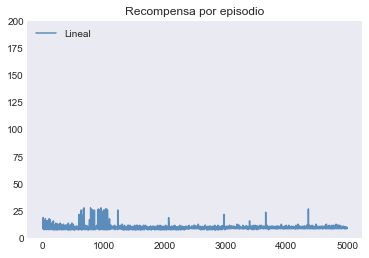

In [11]:
# se muestra el reward/score optenido por episodio
plt.plot(np.array(scoresLineal), label='Lineal', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa por episodio')
plt.legend(loc='upper left')
plt.show()

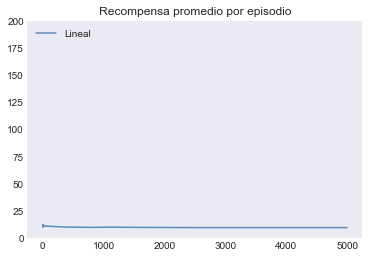

In [12]:
plt.plot(np.array(meanLineal), label='Lineal', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa promedio por episodio')
plt.legend(loc='upper left')
plt.show()

## CartPole: Aproximación con un modelo lineal con 'feature construction'
Supongamos que un problema de aprendizaje por refuerzo que tiene estados con dos dimensiones numéricas. Para un estado $s$, sus dos componentes son $s_1 \in R$ y $s_2 \in R$. Se puede elegir representar $s$ simplemente por las dos dimensiones del estado, de modo que $x(s)=(s_1, s_2)$, pero así, no se puede tener en cuenta ninguna interacción entre estas dimensiones. Además, si tanto $s_1$ como $s_2$ son cero, entonces el valor aproximado también será cero ($x(s)=0$). Ambas limitaciones se pueden superar representando $s$ por el vector de features polinomico $x(s)=(1,s_1,s_2,s_1s_2)$. El 1 inicial, permite la representación de funciones afines en los números de estado originales, y el feature del producto final, $s1s2$, permite que se tengan en cuenta dichas interacciones. También se puede utilizar un vector de features polinomico de mayor orden, como $x(s)=(1,s_1,s_2,s_1s_2,s_1^2,s_2^2,s_1s_2^2,s_1^2s_2,s_1^2s_2^2)$, para poder modelar interacciones mas complejas.

En el caso del entorno CartPole, un predictor lineal que tenga como input unicamente las variables que el entorno emite no puede modelar la relacion entre la posición y velocidad del carro con respecto al angulo y velocidad del poste.

In [22]:
class PolyCartPoleSolver:
    def __init__(self, env, n_episodes=3000, max_env_steps=None, gamma=0.9,
                 epsilon=0.5, epsilon_min=0.01, epsilon_log_decay=0.005, alpha=1e-3,
                 memory_size=10000, batch_size=256, render=False, debug=False):

        self.memory = ReplayMemory(capacity=memory_size)
        self.env = env

        # hyper-parameter setting
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_log_decay
        self.alpha = alpha
        self.n_episodes = n_episodes
        self.batch_size = batch_size
        if max_env_steps is not None:
            self.env._max_episode_steps = max_env_steps
        self.observation_space_size = env.observation_space.shape[0]
        self.action_space_size = env.action_space.n

        self.feature_tuning = PolynomialFeatures(interaction_only=True) #Utilizamos esta funcion para generar mas features (kernel trick?)
        # Initialize feature tunning
        self.feature_tuning.fit(self.env.reset().reshape((1, 4)))

        self.render = render
        self.debug = debug
        if debug:
            self.loss_list = []
        # if gpu is to be used
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Init model 1
        # Use the nn package to define our model as a sequence of layers. nn.Sequential
        # is a Module which contains other Modules, and applies them in sequence to
        # produce its output. Each Linear Module computes output from input using a
        # linear function, and holds internal Tensors for its weight and bias.
        # After constructing the model we use the .to() method to move it to the
        # desired device.
        self.model = LinearModel(self.feature_tuning.n_output_features_, self.action_space_size).to(self.device)
        self.model.train()

        # The nn package also contains definitions of popular loss functions; in this
        # case we will use Mean Squared Error (MSE) as our loss function. Setting
        # reduction='sum' means that we are computing the *sum* of squared errors rather
        # than the mean; this is for consistency with the examples above where we
        # manually compute the loss, but in practice it is more common to use mean
        # squared error as a loss by setting reduction='elementwise_mean'.
        self.loss_fn = torch.nn.MSELoss()

        # Use the optim package to define an Optimizer that will update the weights of
        # the model for us. Here we will use Adam; the optim package contains many other
        # optimization algoriths. The first argument to the Adam constructor tells the
        # optimizer which Tensors it should update.
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=alpha)

        
        #Funcion para generar features y mejorar el modelo lineal
    def preprocess_state(self, state):
        """State and action are stacked horizontally and its features are combined as a polynomial to be passed as an
        input of the approximator"""

        # poly_state converts the horizontal stack into a combination of its parameters i.e.
        # [1, s_1, s_2, s_3, s_4, s_1 s_2, s_1 s_3, ...]
        poly_state = self.feature_tuning.transform(state.reshape((1, 4)))
        return poly_state[0]

    def choose_action(self, state, epsilon):
        """Chooses the next action according to the model trained and the policy"""

        # exploits the current knowledge if the random number > epsilon, otherwise explores
        if np.random.random() <= epsilon:
            return self.env.action_space.sample()
        else:
            with torch.no_grad():
                q = self.model(state)
                argmax = torch.argmax(q)
                return argmax.item()

    def get_epsilon(self, episode):
        """Returns an epsilon that decays over time until a minimum epsilon value is reached; in this case the minimum
        value is returned"""
        return max(self.epsilon_min, self.epsilon * math.exp(-self.epsilon_decay * episode))

    def replay(self):
        """Previously stored (s, a, r, s') tuples are replayed (that is, are added into the model). The size of the
        tuples added is determined by the batch_size parameter"""

        transitions, _ = self.memory.sample(self.batch_size)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))
        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])

        non_final_mask = torch.stack(batch.done)
        state_batch = torch.stack(batch.state)
        action_batch = torch.stack(batch.action)
        reward_batch = torch.stack(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.model(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        with torch.no_grad():
            next_state_values = torch.zeros(self.batch_size, device=self.device)
            next_state_values[non_final_mask] = self.model(non_final_next_states).max(1)[0].detach()
            # Compute the expected Q values
            expected_state_action_values = reward_batch + self.gamma * next_state_values

        # Compute loss
        loss = self.loss_fn(state_action_values, expected_state_action_values.unsqueeze(1))

        if self.debug:
            self.loss_list.append(loss)
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.model.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def run(self):
        """Main loop that controls the execution of the agent"""

        scores = []
        mean_scores = []
        for e in range(self.n_episodes):
            state = self.env.reset()
            state = torch.tensor(self.preprocess_state(state), device=self.device, dtype=torch.float) #Ahora nuestro state está pre-procesado y tiene mas features
            done = False
            cum_reward = 0
            while not done:
                action = self.choose_action(
                    state,
                    self.get_epsilon(e))
                next_state, reward, done, _ = self.env.step(action)
                next_state = torch.tensor(self.preprocess_state(next_state), device=self.device, dtype=torch.float)

                cum_reward += reward
                self.memory.push(
                    state,  # Converted to tensor before
                    torch.tensor([action], device=self.device),
                    None if done else next_state,
                    torch.tensor(reward, device=self.device).clamp_(-1, 1),
                    torch.tensor(not done, device=self.device, dtype=torch.bool))

                if self.memory.__len__() >= self.batch_size:
                    self.replay()
                state = next_state

            scores.append(cum_reward)
            mean_score = np.mean(scores)
            mean_scores.append(mean_score)
            if e % 100 == 0 and self.debug:
                print('[Episode {}] - Mean reward {}.'.format(e, mean_score))

        # noinspection PyUnboundLocalVariable
        print('[Episode {}] - Mean reward {}.'.format(e, mean_score))
        return scores, mean_scores

    def save(self, path):
        torch.save(self.model, path)

    def load(self, path):
        self.model = torch.load(path)

In [23]:
agent = PolyCartPoleSolver(gym.make('CartPole-v0'), n_episodes=5000, debug=True)
scoresPoly, meanPoly = agent.run()

[Episode 0] - Mean reward 37.0.
[Episode 100] - Mean reward 23.792079207920793.
[Episode 200] - Mean reward 20.577114427860696.
[Episode 300] - Mean reward 26.920265780730897.
[Episode 400] - Mean reward 35.224438902743145.
[Episode 500] - Mean reward 36.057884231536924.
[Episode 600] - Mean reward 44.234608985024956.
[Episode 700] - Mean reward 48.328102710413695.
[Episode 800] - Mean reward 52.5330836454432.
[Episode 900] - Mean reward 55.01775804661487.
[Episode 1000] - Mean reward 62.64335664335665.
[Episode 1100] - Mean reward 69.37057220708446.
[Episode 1200] - Mean reward 78.61282264779351.
[Episode 1300] - Mean reward 87.63643351268256.
[Episode 1400] - Mean reward 91.95003568879372.
[Episode 1500] - Mean reward 89.56695536309127.
[Episode 1600] - Mean reward 91.26608369768894.
[Episode 1700] - Mean reward 97.08877131099354.
[Episode 1800] - Mean reward 102.44308717379234.
[Episode 1900] - Mean reward 107.17411888479748.
[Episode 2000] - Mean reward 111.65717141429285.
[Episode

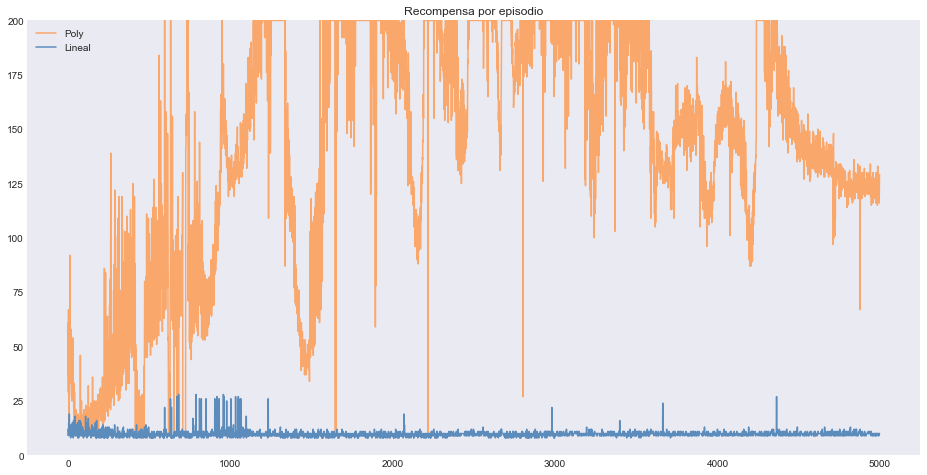

In [24]:
# se muestra el reward/score optenido por episodio
plt.plot(np.array(scoresPoly), label='Poly', c='#faa76c')
plt.plot(np.array(scoresLineal), label='Lineal', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa por episodio')
plt.legend(loc='upper left')
plt.show()

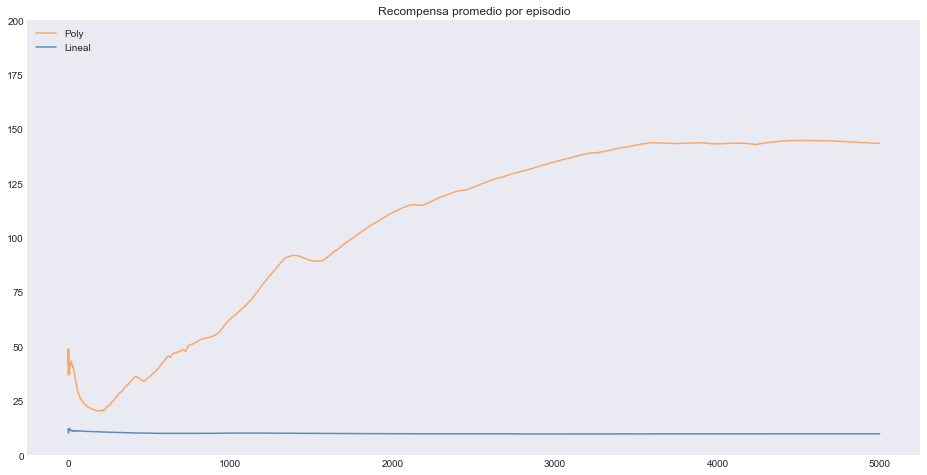

In [25]:
plt.plot(np.array(meanPoly), label='Poly', c='#faa76c')
plt.plot(np.array(meanLineal), label='Lineal', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa promedio por episodio')
plt.legend(loc='upper left')
plt.show()

## CartPole: Aproximación con un modelo lineal y 'Modelo Duplicado'
El objetivo para una actualización de un algoritmo de control basado en TD, depende de la estimación actual ($w_{t}$). Donde el objetivo ($w_{t+1}$), es una función dependiente de los mismos parámetros que se están actualizando. Por ejemplo:

$$w_{t+1}=w_t+\alpha[R_{t+1}+\gamma \operatorname*{max}_a\hat{q}(S_{t+1},a,w_t)-\hat{q}(S_t,A_t,w_t)]\nabla\hat{q}(S_t,A_t,w_t)$$

Esta dependencia de $w_{t}$ puede conducir a oscilaciones y/o divergencias en el entrenamiento del predictor.

Para abordar este problema, el equipo de Google DeepMind desarrollo una solución para acercar el proceso de actualización de los parámetros ($w_t$) de un estimador, a un formato similar al utilizado en el aprendizaje supervisado. Esto es, se utiliza otro modelo predictivo $\tilde{q}$ como objetivo en la actualización de los pesos $w$ del estimador $\hat{q}$. Cada vez que se realizan un cierto número $C$ de actualizaciones de los pesos $w$ en el predictor $\hat{q}$, se realiza una copia de los mismos en el otro modelo $\tilde{q}$ donde se mantienen estos pesos duplicados de forma fija para las próximas $C$ actualizaciones de $w$.

$$w_{t+1}=w_t+\alpha[R_{t+1}+\gamma \operatorname*{max}_a\underline{\tilde{q}(S_{t+1},a,w_t)}-\hat{q}(S_t,A_t,w_t)]\nabla\hat{q}(S_t,A_t,w_t)$$

In [26]:
class PolyDualCartPoleSolver:
    def __init__(self, env, n_episodes=3000, max_env_steps=None, gamma=0.9,
                 epsilon=0.5, epsilon_min=0.01, epsilon_log_decay=0.005, alpha=1e-3,
                 memory_size=10000, batch_size=256, c=10, render=False, debug=False):
        self.memory = ReplayMemory(capacity=memory_size)
        self.env = env

        # hyper-parameter setting
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_log_decay
        self.alpha = alpha
        self.n_episodes = n_episodes
        self.batch_size = batch_size
        self.c = c
        if max_env_steps is not None:
            self.env._max_episode_steps = max_env_steps
        self.observation_space_size = env.observation_space.shape[0]
        self.action_space_size = env.action_space.n

        self.feature_tuning = PolynomialFeatures(interaction_only=True)
        # Initialize feature tunning
        self.feature_tuning.fit(self.env.reset().reshape((1, 4)))

        self.render = render
        self.debug = debug
        if debug:
            self.loss_list = []
        # if gpu is to be used
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Init model 1
        # Use the nn package to define our model as a sequence of layers. nn.Sequential
        # is a Module which contains other Modules, and applies them in sequence to
        # produce its output. Each Linear Module computes output from input using a
        # linear function, and holds internal Tensors for its weight and bias.
        # After constructing the model we use the .to() method to move it to the
        # desired device.
        
        #VER!!! por que uno tiene el eval y otro el train? y que rol cumple el load_state_dict?
        self.model = LinearModel(self.feature_tuning.n_output_features_, self.action_space_size).to(self.device)
        self.model.train()
        self.target = LinearModel(self.feature_tuning.n_output_features_, self.action_space_size).to(self.device)
        self.target.load_state_dict(self.model.state_dict()) #Carga los valores del modelo1 en el target?
        self.target.eval()

        # The nn package also contains definitions of popular loss functions; in this
        # case we will use Mean Squared Error (MSE) as our loss function. Setting
        # reduction='sum' means that we are computing the *sum* of squared errors rather
        # than the mean; this is for consistency with the examples above where we
        # manually compute the loss, but in practice it is more common to use mean
        # squared error as a loss by setting reduction='elementwise_mean'.
        self.loss_fn = torch.nn.MSELoss()

        # Use the optim package to define an Optimizer that will update the weights of
        # the model for us. Here we will use Adam; the optim package contains many other
        # optimization algoriths. The first argument to the Adam constructor tells the
        # optimizer which Tensors it should update.
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=alpha)

    def preprocess_state(self, state):
        """State and action are stacked horizontally and its features are combined as a polynomial to be passed as an
        input of the approximator"""

        # poly_state converts the horizontal stack into a combination of its parameters i.e.
        # [1, s_1, s_2, s_3, s_4, a_1, s_1 s_2, s_1 s_3, ...]
        poly_state = self.feature_tuning.transform(state.reshape((1, 4)))
        return poly_state[0]

    def choose_action(self, state, epsilon):
        """Chooses the next action according to the model trained and the policy"""

        # exploits the current knowledge if the random number > epsilon, otherwise explores
        if np.random.random() <= epsilon:
            return self.env.action_space.sample()
        else:
            with torch.no_grad():
                q = self.model(state)
                argmax = torch.argmax(q)
                return argmax.item()

    def get_epsilon(self, episode):
        """Returns an epsilon that decays over time until a minimum epsilon value is reached; in this case the minimum
        value is returned"""
        return max(self.epsilon_min, self.epsilon * math.exp(-self.epsilon_decay * episode))

    def replay(self):
        """Previously stored (s, a, r, s') tuples are replayed (that is, are added into the model). The size of the
        tuples added is determined by the batch_size parameter"""

        transitions, _ = self.memory.sample(self.batch_size)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))
        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])

        non_final_mask = torch.stack(batch.done)
        state_batch = torch.stack(batch.state)
        action_batch = torch.stack(batch.action)
        reward_batch = torch.stack(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.model(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        with torch.no_grad():
            next_state_values = torch.zeros(self.batch_size, device=self.device)
            next_state_values[non_final_mask] = self.target(non_final_next_states).max(1)[0].detach()
            # Compute the expected Q values
            expected_state_action_values = reward_batch + self.gamma * next_state_values

        # Compute loss
        loss = self.loss_fn(state_action_values, expected_state_action_values.unsqueeze(1))

        if self.debug:
            self.loss_list.append(loss)
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.model.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def run(self):
        """Main loop that controls the execution of the agent"""

        scores = []
        mean_scores = []
        j = 0  # used for model2 update every c steps
        for e in range(self.n_episodes):
            state = self.env.reset()
            state = torch.tensor(self.preprocess_state(state), device=self.device, dtype=torch.float)
            done = False
            cum_reward = 0
            while not done:
                action = self.choose_action(
                    state,
                    self.get_epsilon(e))
                next_state, reward, done, _ = self.env.step(action)
                next_state = torch.tensor(self.preprocess_state(next_state), device=self.device, dtype=torch.float)

                cum_reward += reward
                self.memory.push(
                    state,  # Converted to tensor before
                    torch.tensor([action], device=self.device),
                    None if done else next_state,
                    torch.tensor(reward, device=self.device).clamp_(-1, 1),
                    torch.tensor(not done, device=self.device, dtype=torch.bool))

                if self.memory.__len__() >= self.batch_size:
                    self.replay()
                state = next_state
                j += 1
                # update second model
                if j % self.c == 0:
                    self.target.load_state_dict(self.model.state_dict())
                    self.target.eval()

            scores.append(cum_reward)
            mean_score = np.mean(scores)
            mean_scores.append(mean_score)
            if e % 100 == 0 and self.debug:
                print('[Episode {}] - Mean reward {}.'.format(e, mean_score))

        # noinspection PyUnboundLocalVariable
        print('[Episode {}] - Mean reward {}.'.format(e, mean_score))
        return scores, mean_scores

    def save(self, path):
        torch.save(self.model, path)

    def load(self, path):
        self.model = torch.load(path)

In [27]:
agent = PolyDualCartPoleSolver(gym.make('CartPole-v0'), n_episodes=5000, debug=True)
scoresPolyDual, meanPolyDual = agent.run()

[Episode 0] - Mean reward 12.0.
[Episode 100] - Mean reward 12.633663366336634.
[Episode 200] - Mean reward 11.711442786069652.
[Episode 300] - Mean reward 11.26578073089701.
[Episode 400] - Mean reward 11.109725685785536.
[Episode 500] - Mean reward 11.221556886227544.
[Episode 600] - Mean reward 12.916805324459235.
[Episode 700] - Mean reward 19.840228245363765.
[Episode 800] - Mean reward 22.454431960049938.
[Episode 900] - Mean reward 27.50610432852386.
[Episode 1000] - Mean reward 34.05594405594405.
[Episode 1100] - Mean reward 40.525885558583106.
[Episode 1200] - Mean reward 53.55120732722731.
[Episode 1300] - Mean reward 64.61721752498079.
[Episode 1400] - Mean reward 72.63811563169165.
[Episode 1500] - Mean reward 76.51565622918055.
[Episode 1600] - Mean reward 80.0.
[Episode 1700] - Mean reward 82.41446208112875.
[Episode 1800] - Mean reward 84.24430871737924.
[Episode 1900] - Mean reward 85.75960021041557.
[Episode 2000] - Mean reward 87.21989005497251.
[Episode 2100] - Mean 

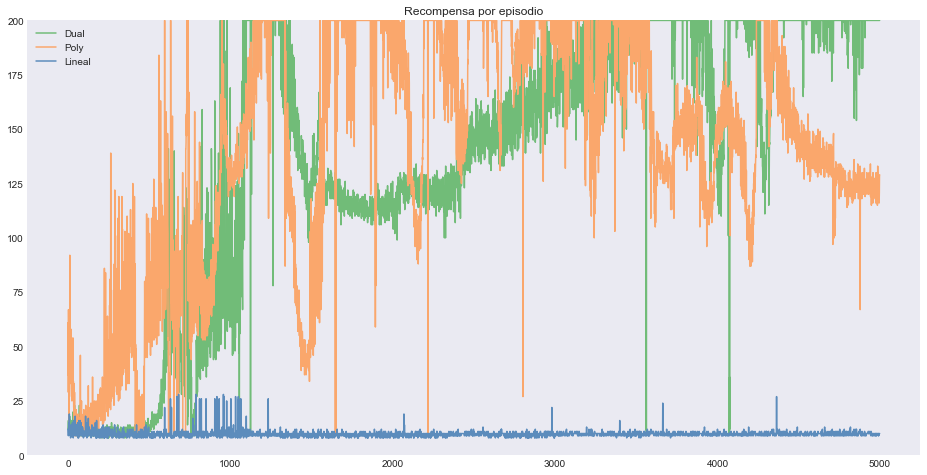

In [28]:
# se muestra el reward/score optenido por episodio
plt.plot(np.array(scoresPolyDual), label='Dual', c='#71bc78')
plt.plot(np.array(scoresPoly), label='Poly', c='#faa76c')
plt.plot(np.array(scoresLineal), label='Lineal', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa por episodio')
plt.legend(loc='upper left')
plt.show()

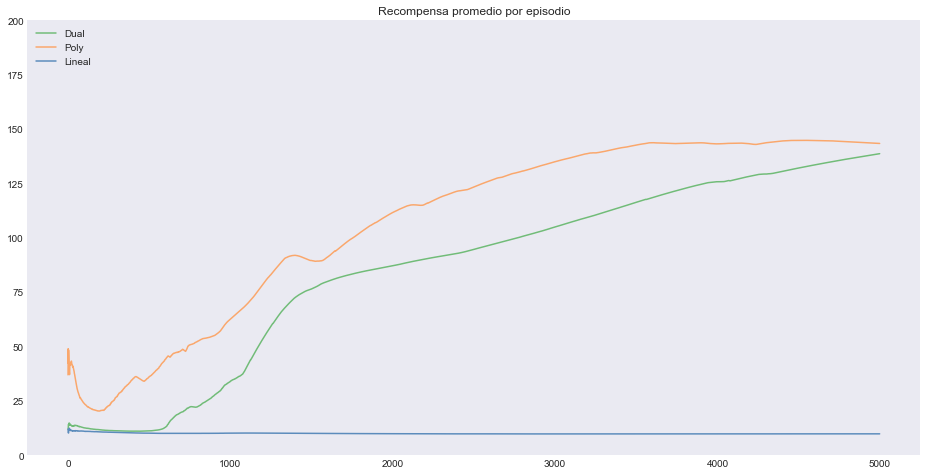

In [29]:
plt.plot(np.array(meanPolyDual), label='Dual', c='#71bc78')
plt.plot(np.array(meanPoly), label='Poly', c='#faa76c')
plt.plot(np.array(meanLineal), label='Lineal', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa promedio por episodio')
plt.legend(loc='upper left')
plt.show()

## CartPole: Aproximación con Redes Neuronales
Como ultima mejora, vamos a reemplazar el aproximador lineal por una red neuronal. En este caso, estamos trabajando con un entorno donde directamente el agente percibe los features que representan el estado del mismo. Por lo tanto, utilizaremos una red neuronal 'fully connected' de 3 capas con la siguiente arquitectura:

![nn_dense](images/nn_dense.png)

En este caso, como el aproximador usado es 'no lineal', no tenemos necesidad de hacer un pre-prosesamiento de los features, como en el caso del agente 'SGD_Poly' y 'SGD_Poly_Dual', para poder capturar las relaciones no lineales entre los distintos features del entorno.

### Funciones de activación:
![activation_functions](images/activation_functions.png)

In [4]:
class Net(nn.Module):

    def __init__(self, _input_size: int, _output_size: int, _hidden_layers: int, _hidden_size: int):
        super(Net, self).__init__()
        self.input = nn.Linear(_input_size, _hidden_size)
        self.hidden_layers = _hidden_layers
        self.hidden = []
        for i in range(_hidden_layers):
            layer = nn.Linear(_hidden_size, _hidden_size)
            self.add_module('h'+str(i), layer)
            self.hidden.append(layer)
        self.output = nn.Linear(_hidden_size, _output_size)

        # init weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.input(x))
        for i in range(self.hidden_layers):
            x = F.relu(self.hidden[i](x))
        x = self.output(x)
        return x

In [31]:
class DQN:
    def __init__(self, env, n_episodes=3000, max_env_steps=None, gamma=0.9,
                 epsilon=0.5, epsilon_min=0.05, epsilon_log_decay=0.001, alpha=1e-3,
                 memory_size=10000, batch_size=256, c=10, hidden_layers=2, hidden_size=24,
                 render=False, debug=False):

        self.memory = ReplayMemory(capacity=memory_size)
        self.env = env

        # hyper-parameter setting
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_log_decay
        self.alpha = alpha
        self.n_episodes = n_episodes
        self.batch_size = batch_size
        self.c = c
        if max_env_steps is not None:
            self.env._max_episode_steps = max_env_steps
        self.observation_space_size = env.observation_space.shape[0]
        self.action_space_size = env.action_space.n

        self.render = render
        self.debug = debug
        if debug:
            self.loss_list = []
        # if gpu is to be used
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Init model 1
        # Use the nn package to define our model as a sequence of layers. nn.Sequential
        # is a Module which contains other Modules, and applies them in sequence to
        # produce its output. Each Linear Module computes output from input using a
        # linear function, and holds internal Tensors for its weight and bias.
        # After constructing the model we use the .to() method to move it to the
        # desired device.
        self.model = Net(self.observation_space_size, self.action_space_size, hidden_layers, hidden_size) \
            .to(self.device)
        self.target = Net(self.observation_space_size, self.action_space_size, hidden_layers, hidden_size) \
            .to(self.device)
        self.target.load_state_dict(self.model.state_dict()) #Que hace esta funcion? Será que copia los pesos del modelo original?
        
        #Por que target evaluacion??? Será porque no optimiza ni calcula la actualizacion de sus pesos y se queda fijo?
        self.target.eval() 
        
        #Por que model train? Será que en este caso la red si optimiza (Adam), y actualiza los pesos?
        self.model.train()

        # The nn package also contains definitions of popular loss functions; in this
        # case we will use Mean Squared Error (MSE) as our loss function. Setting
        # reduction='sum' means that we are computing the *sum* of squared errors rather
        # than the mean; this is for consistency with the examples above where we
        # manually compute the loss, but in practice it is more common to use mean
        # squared error as a loss by setting reduction='elementwise_mean'.
        self.loss_fn = torch.nn.MSELoss()

        # Use the optim package to define an Optimizer that will update the weights of
        # the model for us. Here we will use Adam; the optim package contains many other
        # optimization algoriths. The first argument to the Adam constructor tells the
        # optimizer which Tensors it should update.
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=alpha)

    def choose_action(self, state, epsilon):
        """Chooses the next action according to the model trained and the policy"""

        # exploits the current knowledge if the random number > epsilon, otherwise explores
        if np.random.random() <= epsilon:
            return self.env.action_space.sample()
        else:t
            with torch.no_grad():
                q = self.model(state)
                argmax = torch.argmax(q)
                return argmax.item()

    def get_epsilon(self, episode):
        """Returns an epsilon that decays over time until a minimum epsilon value is reached; in this case the minimum
        value is returned"""
        return max(self.epsilon_min, self.epsilon * math.exp(-self.epsilon_decay * episode))

    #En este método se computan las Q, se obtiene la funcion de error, se optimiza con Adam, y se hace propagación hacia atras actualizando los pesos
    def replay(self):
        """Previously stored (s, a, r, s') tuples are replayed (that is, are added into the model). The size of the
        tuples added is determined by the batch_size parameter"""

        transitions, _ = self.memory.sample(self.batch_size)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))
        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])

        non_final_mask = torch.stack(batch.done)
        state_batch = torch.stack(batch.state)
        action_batch = torch.stack(batch.action)
        reward_batch = torch.stack(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.model(state_batch).gather(1, action_batch) #Valores q del modelo

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        
        with torch.no_grad(): #Usamos no_grad para deshabilitar la optimizacion y el backpropa, ya que estamos trabajanto sobre los pesos "fijos" del target?
            next_state_values = torch.zeros(self.batch_size, device=self.device)
            next_state_values[non_final_mask] = self.target(non_final_next_states).max(1)[0].detach() #Valor Q del siguiente estado
            # Compute the expected Q values
            expected_state_action_values = reward_batch + self.gamma * next_state_values  #Valores Q del target

        # Compute loss
        loss = self.loss_fn(state_action_values, expected_state_action_values.unsqueeze(1))

        if self.debug:
            self.loss_list.append(loss)
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.model.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def run(self):
        """Main loop that controls the execution of the agent"""

        scores = []
        mean_scores = []
        j = 0  # used for model2 update every c steps
        for e in range(self.n_episodes):
            state = self.env.reset()
            state = torch.tensor(state, device=self.device, dtype=torch.float)
            done = False
            cum_reward = 0
            while not done:
                action = self.choose_action(
                    state,
                    self.get_epsilon(e))
                next_state, reward, done, _ = self.env.step(action)
                next_state = torch.tensor(next_state, device=self.device, dtype=torch.float)

                cum_reward += reward
                
                #Almacena en la memoria de experiencias (s,a,r,s')
                self.memory.push(
                    state,  #Converted to tensor in choose_action method
                    torch.tensor([action], device=self.device),
                    None if done else next_state,
                    torch.tensor(reward, device=self.device).clamp_(-1, 1),
                    torch.tensor(not done, device=self.device, dtype=torch.bool))

                #Una vez que la memoria cabe en el batch_size, el algoritmo SIEMPRE entrena con la memoria, NUNCA MAS con la experiencia actual. (ver metodo replay())
                if self.memory.__len__() >= self.batch_size:
                    self.replay()

                state = next_state
                j += 1

                # update second model
                if j % self.c == 0:
                    self.target.load_state_dict(self.model.state_dict()) #La red2(target) actualiza los valores (pesos), con los valores actuales del modelo (red1)
                    self.target.eval() 

            scores.append(cum_reward)
            mean_score = np.mean(scores)
            mean_scores.append(mean_score)
            if e % 100 == 0 and self.debug:
                print('[Episode {}] - Mean reward {}.'.format(e, mean_score))

        # noinspection PyUnboundLocalVariable
        print('[Episode {}] - Mean reward {}.'.format(e, mean_score))
        return scores, mean_scores

    def save(self, path):
        torch.save(self.model, path)

    def load(self, path):
        self.model = torch.load(path)


In [33]:
agent = DQN(gym.make('CartPole-v0'), n_episodes=5000, debug=True)
scoresDQN, meanDQN = agent.run()

[Episode 0] - Mean reward 9.0.
[Episode 100] - Mean reward 77.6930693069307.
[Episode 200] - Mean reward 76.6318407960199.
[Episode 300] - Mean reward 75.07641196013289.
[Episode 400] - Mean reward 71.16957605985037.
[Episode 500] - Mean reward 68.92814371257485.
[Episode 600] - Mean reward 68.94009983361065.
[Episode 700] - Mean reward 68.93295292439372.
[Episode 800] - Mean reward 69.07990012484395.
[Episode 900] - Mean reward 68.7291897891232.
[Episode 1000] - Mean reward 70.001998001998.
[Episode 1100] - Mean reward 71.4314259763851.
[Episode 1200] - Mean reward 73.76935886761032.
[Episode 1300] - Mean reward 76.42736356648732.
[Episode 1400] - Mean reward 79.45324768022842.
[Episode 1500] - Mean reward 83.19187208527649.
[Episode 1600] - Mean reward 87.19800124921923.
[Episode 1700] - Mean reward 90.00764256319812.
[Episode 1800] - Mean reward 93.12159911160467.
[Episode 1900] - Mean reward 95.80641767490795.
[Episode 2000] - Mean reward 97.71264367816092.
[Episode 2100] - Mean re

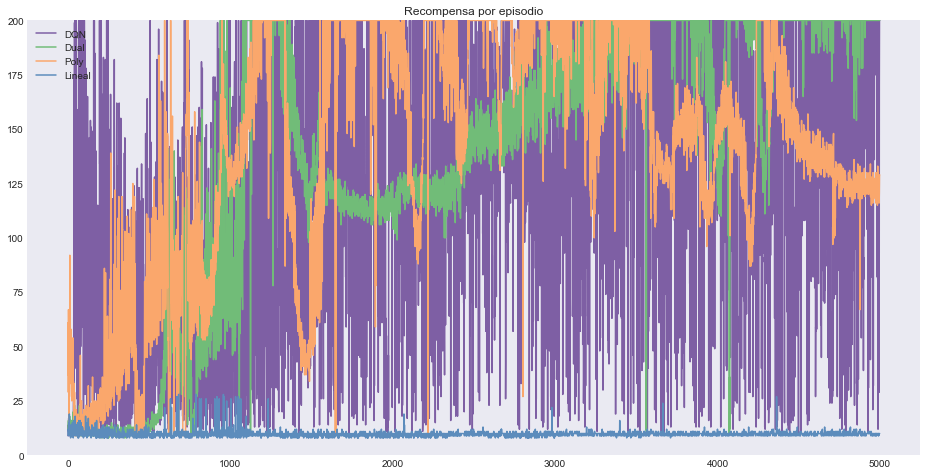

In [35]:
# se muestra el reward/score optenido por episodio
plt.plot(np.array(scoresDQN), label='DQN', c='#7e5fa4')
plt.plot(np.array(scoresPolyDual), label='Dual', c='#71bc78')
plt.plot(np.array(scoresPoly), label='Poly', c='#faa76c')
plt.plot(np.array(scoresLineal), label='Lineal', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa por episodio')
plt.legend(loc='upper left')
plt.show()

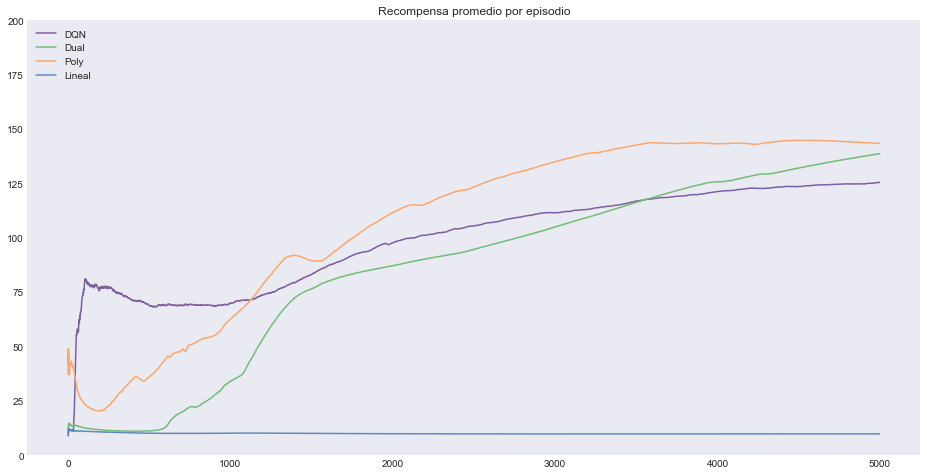

In [36]:
plt.plot(np.array(meanDQN), label='DQN', c='#7e5fa4')
plt.plot(np.array(meanPolyDual), label='Dual', c='#71bc78')
plt.plot(np.array(meanPoly), label='Poly', c='#faa76c')
plt.plot(np.array(meanLineal), label='Lineal', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa promedio por episodio')
plt.legend(loc='upper left')
plt.show()

## Ejercicios Lab Final

Se pide:

1) Implementar [Double DQN (DDQN)](https://www.aaai.org/ocs/index.php/AAAI/AAAI16/paper/view/12389/11847).

2) Implementar [Dueling DDQN](https://arxiv.org/pdf/1511.06581.pdf).

3) Cambiar el entorno por uno nuevo a elección

4) Implementar [Prioritized Experience Replay (PER)](https://arxiv.org/pdf/1511.05952.pdf) (**Opcional**).

**Comentar en un notebook lo realizado paso a paso, mostrando resultados parciales y finales. Y subirlo a un repositorio en GitHub** 

**Recomendación General**: No se sugiere hacer este TP desde jupyter notebook/lab sino desde un IDE estilo "Pycharm" o "Visual Studio Code", debido a que los algoritmos de RL suelen requerir un debug paso a paso, tanto para corregir errores como para entender mejor cómo funcionan los mismos.

**Opcional**: Implementación de un agente DQN convolucional que aprende a jugar a Atari© Space Invaders© ([link](https://github.com/simoninithomas/Deep_reinforcement_learning_Course/blob/master/Deep%20Q%20Learning/Space%20Invaders/DQN%20Atari%20Space%20Invaders.ipynb))

In [ ]:
class Net(nn.Module):

    def __init__(self, _input_size: int, _output_size: int, _hidden_layers: int, _hidden_size: int):
        super(Net, self).__init__()
        self.input = nn.Linear(_input_size, _hidden_size)
        self.hidden_layers = _hidden_layers
        self.hidden = []
        for i in range(_hidden_layers):
            layer = nn.Linear(_hidden_size, _hidden_size)
            self.add_module('h'+str(i), layer)
            self.hidden.append(layer)
        self.output = nn.Linear(_hidden_size, _output_size)

        # init weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.input(x))
        for i in range(self.hidden_layers):
            x = F.relu(self.hidden[i](x))
        x = self.output(x)
        return x

1) Implementación de Double_DQN

In [2]:
class Double_DQN:
    def __init__(self, env, n_episodes=3000, max_env_steps=None, gamma=0.9,
                 epsilon=0.5, epsilon_min=0.05, epsilon_log_decay=0.001, alpha=1e-3,
                 memory_size=10000, batch_size=256, c=10, hidden_layers=2, hidden_size=24,
                 render=False, debug=False):

        self.memory = ReplayMemory(capacity=memory_size)
        self.env = env

        # hyper-parameter setting
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_log_decay
        self.alpha = alpha
        self.n_episodes = n_episodes
        self.batch_size = batch_size
        self.c = c
        if max_env_steps is not None:
            self.env._max_episode_steps = max_env_steps
        self.observation_space_size = env.observation_space.shape[0]
        self.action_space_size = env.action_space.n

        self.render = render
        self.debug = debug
        if debug:
            self.loss_list = []
        # if gpu is to be used
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Init model 1
        # Use the nn package to define our model as a sequence of layers. nn.Sequential
        # is a Module which contains other Modules, and applies them in sequence to
        # produce its output. Each Linear Module computes output from input using a
        # linear function, and holds internal Tensors for its weight and bias.
        # After constructing the model we use the .to() method to move it to the
        # desired device.
        self.model = Net(self.observation_space_size, self.action_space_size, hidden_layers, hidden_size) \
            .to(self.device)
        self.target = Net(self.observation_space_size, self.action_space_size, hidden_layers, hidden_size) \
            .to(self.device)
        self.target.load_state_dict(self.model.state_dict()) #Que hace esta funcion? Será que copia los pesos del modelo original?
        
        #Por que target evaluacion??? Será porque no optimiza ni calcula la actualizacion de sus pesos y se queda fijo?
        self.target.eval() 
        
        #Por que model train? Será que en este caso la red si optimiza (Adam), y actualiza los pesos?
        self.model.train()

        # The nn package also contains definitions of popular loss functions; in this
        # case we will use Mean Squared Error (MSE) as our loss function. Setting
        # reduction='sum' means that we are computing the *sum* of squared errors rather
        # than the mean; this is for consistency with the examples above where we
        # manually compute the loss, but in practice it is more common to use mean
        # squared error as a loss by setting reduction='elementwise_mean'.
        self.loss_fn = torch.nn.MSELoss()

        # Use the optim package to define an Optimizer that will update the weights of
        # the model for us. Here we will use Adam; the optim package contains many other
        # optimization algoriths. The first argument to the Adam constructor tells the
        # optimizer which Tensors it should update.
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=alpha)

    def choose_action(self, state, epsilon):
        """Chooses the next action according to the model trained and the policy"""

        # exploits the current knowledge if the random number > epsilon, otherwise explores
        if np.random.random() <= epsilon:
            return self.env.action_space.sample()
        else:
            with torch.no_grad():
                q = self.model(state)
                argmax = torch.argmax(q)
                return argmax.item()

    def get_epsilon(self, episode):
        #"""Returns an epsilon that decays over time until a minimum epsilon value is reached; in this case the minimum
        #value is returned"""
        return max(self.epsilon_min, self.epsilon * math.exp(-self.epsilon_decay * episode))

    #En este método se computan las Q, se obtiene la funcion de error, se optimiza con Adam, y se hace propagación hacia atras actualizando los pesos
    def replay(self):
        #"""Previously stored (s, a, r, s') tuples are replayed (that is, are added into the model). The size of the
        #tuples added is determined by the batch_size parameter"""

        transitions, _ = self.memory.sample(self.batch_size)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))
        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])

        non_final_mask = torch.stack(batch.done)
        state_batch = torch.stack(batch.state)
        action_batch = torch.stack(batch.action)
        reward_batch = torch.stack(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.model(state_batch).gather(1, action_batch) #Valores q del modelo. (Como lo calcula???)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        
        with torch.no_grad(): #Usamos no_grad para deshabilitar la optimizacion y el backpropa, ya que estamos trabajanto sobre los pesos "fijos" del target?
            
            #Modelo (Red1)
        
            #Inicializamos el tensor en el que pondremos los argumentos (acciones) que maximizan el siguiente estado
            next_state_argmax = torch.zeros(self.batch_size, device=self.device)
            
            #ARGMAXaQ(s',a)
            next_state_argmax = torch.argmax(self.model(non_final_next_states), dim=1).type(torch.FloatTensor) #Acciones que maximizan el valor de Q para s', En el modelo (Red1). Fue necesario convertir a Float las acciones
            argmax_values = next_state_argmax.unsqueeze(1).type(torch.LongTensor) #Redimensionamos y establecemos el dtype(Long) del tensor de acciones para que nos quede igual que el de action_batch, y poder calular los Q valores en el target (Red2) 
            
            #Target (Red2)

            #Inicializamos en este caso 2 tensores, para poder hacer el pase del tensor2t dimension=len(non_final_states) al tensor original dimension=len(batch_size)=256 
            next_state_action_values = torch.zeros(self.batch_size, device=self.device)
            next_state_action_values2t = torch.zeros(self.batch_size, device=self.device)

            #Obtenemos los Q valores para la cantidad de estados reducidos (non_final) 
            next_state_action_values2t = self.target(non_final_next_states).gather(1,argmax_values) #Hallamos el valor de Q para s' en el target (Red2) dada las acciones argmax obtenidas previamente(en la red1).
            
            #Completamos el tensor con los Q valores de los estados faltantes(finales) (non_final_mask)
            next_state_action_values[non_final_mask] = next_state_action_values2t.view(len(non_final_next_states)) #Redimensionamos el tensor al tamaño del batch (contabilizamos los estados finales/nulos), ya que debe tener la misma dimension. Y asi obtener el Q*(s,a) y el loss correspondiente.
      

            # Obtenemos el Q*(s,a)target o YtDouble.
            expected_state_action_values = reward_batch + self.gamma * next_state_action_values  #Valores del Q-target

            
        # Compute loss
        loss = self.loss_fn(state_action_values, expected_state_action_values.unsqueeze(1))#unsqueeze redimensiona el tensor "expected" para matchear el loss, pero como acepta (1) y no tira error "argument input position 1 must be tensor, no int"??

        if self.debug:
            self.loss_list.append(loss)
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.model.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def run(self):
        #"""Main loop that controls the execution of the agent"""

        scores = []
        mean_scores = []
        j = 0  # used for model2 update every c steps
        for e in range(self.n_episodes):
            state = self.env.reset()
            state = torch.tensor(state, device=self.device, dtype=torch.float)
            done = False
            cum_reward = 0
            while not done:
                action = self.choose_action(
                    state,
                    self.get_epsilon(e))
                next_state, reward, done, _ = self.env.step(action)
                next_state = torch.tensor(next_state, device=self.device, dtype=torch.float)

                cum_reward += reward
                
                #Almacena en la memoria de experiencias (s,a,r,s')
                self.memory.push(
                    state,  #Converted to tensor in choose_action method
                    torch.tensor([action], device=self.device),
                    None if done else next_state,
                    torch.tensor(reward, device=self.device).clamp_(-1, 1),
                    torch.tensor(not done, device=self.device, dtype=torch.bool))

                #Una vez que la memoria cabe en el batch_size, el algoritmo SIEMPRE entrena con la memoria, NUNCA MAS con la experiencia actual. (ver metodo replay())
                if self.memory.__len__() >= self.batch_size:
                    self.replay()

                state = next_state
                j += 1

                # update second model
                if j % self.c == 0:
                    self.target.load_state_dict(self.model.state_dict()) #La red2(target) actualiza los valores (pesos), con los valores actuales del modelo (red1)
                    self.target.eval() 

            scores.append(cum_reward)
            mean_score = np.mean(scores)
            mean_scores.append(mean_score)
            if e % 100 == 0 and self.debug:
                print('[Episode {}] - Mean reward {}.'.format(e, mean_score))

        # noinspection PyUnboundLocalVariable
        print('[Episode {}] - Mean reward {}.'.format(e, mean_score))
        return scores, mean_scores

    def save(self, path):
        torch.save(self.model, path)

    def load(self, path):
        self.model = torch.load(path)



In [5]:
agent = Double_DQN(gym.make('CartPole-v0'), n_episodes=5000, debug=True)
scoresDDQN, meanDDQN = agent.run()

[Episode 0] - Mean reward 10.0.
[Episode 100] - Mean reward 57.18811881188119.
[Episode 200] - Mean reward 58.38805970149254.
[Episode 300] - Mean reward 53.52823920265781.
[Episode 400] - Mean reward 48.29925187032419.
[Episode 500] - Mean reward 50.69860279441118.
[Episode 600] - Mean reward 51.76206322795341.
[Episode 700] - Mean reward 55.502139800285306.
[Episode 800] - Mean reward 57.55680399500624.
[Episode 900] - Mean reward 57.13984461709212.
[Episode 1000] - Mean reward 57.277722277722276.
[Episode 1100] - Mean reward 58.66030881017257.
[Episode 1200] - Mean reward 61.385512073272274.
[Episode 1300] - Mean reward 63.63028439661799.
[Episode 1400] - Mean reward 66.63597430406853.
[Episode 1500] - Mean reward 67.48700866089274.
[Episode 1600] - Mean reward 69.31792629606495.
[Episode 1700] - Mean reward 72.0435038212816.
[Episode 1800] - Mean reward 73.02220988339812.
[Episode 1900] - Mean reward 76.03419253024724.
[Episode 2000] - Mean reward 79.28835582208896.
[Episode 2100] 

NameError: name 'scoresDQN' is not defined

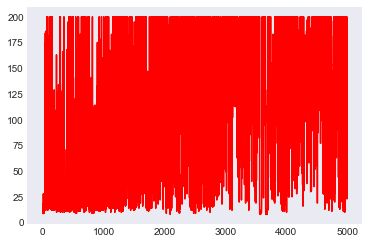

In [6]:
# se muestra el reward/score optenido por episodio
plt.plot(np.array(scoresDDQN), label='Double_DQN', c='r')
plt.plot(np.array(scoresDQN), label='DQN', c='#7e5fa4')
plt.plot(np.array(scoresPolyDual), label='Dual', c='#71bc78')
plt.plot(np.array(scoresPoly), label='Poly', c='#faa76c')
plt.plot(np.array(scoresLineal), label='Lineal', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa por episodio')
plt.legend(loc='upper left')
plt.show()

NameError: name 'meanDQN' is not defined

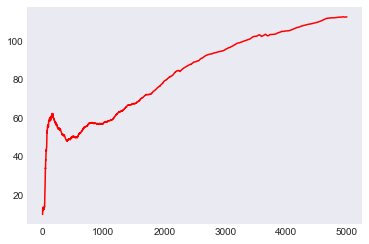

In [7]:
plt.plot(np.array(meanDDQN), label='Double_DQN', c='r')
plt.plot(np.array(meanDQN), label='DQN', c='#7e5fa4')
plt.plot(np.array(meanPolyDual), label='Dual', c='#71bc78')
plt.plot(np.array(meanPoly), label='Poly', c='#faa76c ')
plt.plot(np.array(meanLineal), label='Lineal', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa promedio por episodio')
plt.legend(loc='upper left')
plt.show()

2) Implementación de Dueling_DQN

In [6]:
#Arquitectura Dueling
class Net(nn.Module):

    def __init__(self, _input_size: int, _output_size: int, _hidden_layers: int, _hidden_size: int):
        super(Net, self).__init__()
        self.input = nn.Linear(_input_size, _hidden_size)
        self.hidden_layers = _hidden_layers
        self.hidden = []
        for i in range(_hidden_layers):
            layer = nn.Linear(_hidden_size, _hidden_size)
            self.add_module('h'+str(i), layer)
            self.hidden.append(layer)
        #self.output = nn.Linear(_hidden_size, _output_size)
        self.output_value = nn.Linear(_hidden_size, 1) #Capa de salida del state_value V(s)
        self.output_adventage = nn.Linear(_hidden_size, _output_size) #Capa de salida del action_Adventage A(s,a)

        # init weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.input(x)) #Capa de entrada fully
        for i in range(self.hidden_layers): #Capas ocultas (convolucionales)
            x = F.relu(self.hidden[i](x)) 
        
        x_value = self.output_value(x) #Valor V(s)
        x_adventage = self.output_adventage(x) #Valores A(s,a)
        x_q = x_value + (x_adventage - x_adventage.mean()) # Valores de Q(s,a) = V(s) + (A(s,a) - Media(A)) 

        #x = self.output(x) #Capa de salida fully
        return x_q

In [7]:
class Dueling_DQN:
    def __init__(self, env, n_episodes=3000, max_env_steps=None, gamma=0.9,
                 epsilon=0.5, epsilon_min=0.05, epsilon_log_decay=0.001, alpha=1e-3,
                 memory_size=10000, batch_size=256, c=10, hidden_layers=2, hidden_size=24,
                 render=False, debug=False):

        self.memory = ReplayMemory(capacity=memory_size)
        self.env = env

        # hyper-parameter setting
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_log_decay
        self.alpha = alpha
        self.n_episodes = n_episodes
        self.batch_size = batch_size
        self.c = c
        if max_env_steps is not None:
            self.env._max_episode_steps = max_env_steps
        self.observation_space_size = env.observation_space.shape[0]
        self.action_space_size = env.action_space.n

        self.render = render
        self.debug = debug
        if debug:
            self.loss_list = []
        # if gpu is to be used
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Init model 1
        # Use the nn package to define our model as a sequence of layers. nn.Sequential
        # is a Module which contains other Modules, and applies them in sequence to
        # produce its output. Each Linear Module computes output from input using a
        # linear function, and holds internal Tensors for its weight and bias.
        # After constructing the model we use the .to() method to move it to the
        # desired device.
        self.model = Net(self.observation_space_size, self.action_space_size, hidden_layers, hidden_size) \
            .to(self.device)
        self.target = Net(self.observation_space_size, self.action_space_size, hidden_layers, hidden_size) \
            .to(self.device)
        self.target.load_state_dict(self.model.state_dict()) #Que hace esta funcion? Será que copia los pesos del modelo original?
        
        #Por que target evaluacion??? Será porque no optimiza ni calcula la actualizacion de sus pesos y se queda fijo?
        self.target.eval() 
        
        #Por que model train? Será que en este caso la red si optimiza (Adam), y actualiza los pesos?
        self.model.train()

        # The nn package also contains definitions of popular loss functions; in this
        # case we will use Mean Squared Error (MSE) as our loss function. Setting
        # reduction='sum' means that we are computing the *sum* of squared errors rather
        # than the mean; this is for consistency with the examples above where we
        # manually compute the loss, but in practice it is more common to use mean
        # squared error as a loss by setting reduction='elementwise_mean'.
        self.loss_fn = torch.nn.MSELoss()

        # Use the optim package to define an Optimizer that will update the weights of
        # the model for us. Here we will use Adam; the optim package contains many other
        # optimization algoriths. The first argument to the Adam constructor tells the
        # optimizer which Tensors it should update.
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=alpha)

    def choose_action(self, state, epsilon):
        """Chooses the next action according to the model trained and the policy"""

        # exploits the current knowledge if the random number > epsilon, otherwise explores
        if np.random.random() <= epsilon:
            return self.env.action_space.sample()
        else:
            with torch.no_grad():
                q = self.model(state)
                argmax = torch.argmax(q)
                return argmax.item()

    def get_epsilon(self, episode):
        #"""Returns an epsilon that decays over time until a minimum epsilon value is reached; in this case the minimum
        #value is returned"""
        return max(self.epsilon_min, self.epsilon * math.exp(-self.epsilon_decay * episode))

    #En este método se computan las Q, se obtiene la funcion de error, se optimiza con Adam, y se hace propagación hacia atras actualizando los pesos
    def replay(self):
        #"""Previously stored (s, a, r, s') tuples are replayed (that is, are added into the model). The size of the
        #tuples added is determined by the batch_size parameter"""

        transitions, _ = self.memory.sample(self.batch_size)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))
        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])

        non_final_mask = torch.stack(batch.done)
        state_batch = torch.stack(batch.state)
        action_batch = torch.stack(batch.action)
        reward_batch = torch.stack(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.model(state_batch).gather(1, action_batch) #Valores q del modelo. (Como lo calcula???)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        
        with torch.no_grad(): #Usamos no_grad para deshabilitar la optimizacion y el backpropa, ya que estamos trabajanto sobre los pesos "fijos" del target?
            
            expected_state_values = torch.zeros(self.batch_size, device=self.device)
            
            expected_state_values[non_final_mask] = self.target(non_final_next_states).max(1)[0].detach()#Acciones que maximizan el valor de Q para s', En el modelo (Red1). Fue necesario convertir a Float las acciones
        

            # Obtenemos el Q*(s,a)target o YtDouble.
            expected_state_action_values = reward_batch + self.gamma * expected_state_values  #Valores del Q-target

            
        # Compute loss
        loss = self.loss_fn(state_action_values, expected_state_action_values.unsqueeze(1))#unsqueeze redimensiona el tensor "expected" para matchear el loss, pero como acepta (1) y no tira error "argument input position 1 must be tensor, no int"??

        if self.debug:
            self.loss_list.append(loss)
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.model.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def run(self):
        #"""Main loop that controls the execution of the agent"""

        scores = []
        mean_scores = []
        j = 0  # used for model2 update every c steps
        for e in range(self.n_episodes):
            state = self.env.reset()
            state = torch.tensor(state, device=self.device, dtype=torch.float)
            done = False
            cum_reward = 0
            while not done:
                action = self.choose_action(
                    state,
                    self.get_epsilon(e))
                next_state, reward, done, _ = self.env.step(action)
                next_state = torch.tensor(next_state, device=self.device, dtype=torch.float)

                cum_reward += reward
                
                #Almacena en la memoria de experiencias (s,a,r,s')
                self.memory.push(
                    state,  #Converted to tensor in choose_action method
                    torch.tensor([action], device=self.device),
                    None if done else next_state,
                    torch.tensor(reward, device=self.device).clamp_(-1, 1),
                    torch.tensor(not done, device=self.device, dtype=torch.bool))

                #Una vez que la memoria cabe en el batch_size, el algoritmo SIEMPRE entrena con la memoria, NUNCA MAS con la experiencia actual. (ver metodo replay())
                if self.memory.__len__() >= self.batch_size:
                    self.replay()

                state = next_state
                j += 1

                # update second model
                if j % self.c == 0:
                    self.target.load_state_dict(self.model.state_dict()) #La red2(target) actualiza los valores (pesos), con los valores actuales del modelo (red1)
                    self.target.eval() 

            scores.append(cum_reward)
            mean_score = np.mean(scores)
            mean_scores.append(mean_score)
            if e % 100 == 0 and self.debug:
                print('[Episode {}] - Mean reward {}.'.format(e, mean_score))

        # noinspection PyUnboundLocalVariable
        print('[Episode {}] - Mean reward {}.'.format(e, mean_score))
        return scores, mean_scores

    def save(self, path):
        torch.save(self.model, path)

    def load(self, path):
        self.model = torch.load(path)



In [4]:
agent = Dueling_DQN(gym.make('CartPole-v0'), n_episodes=5000, debug=True)
scores_DuelDQN, mean_DuelDQN = agent.run()

[Episode 0] - Mean reward 9.0.
[Episode 100] - Mean reward 65.85148514851485.
[Episode 200] - Mean reward 57.114427860696516.
[Episode 300] - Mean reward 57.33887043189369.
[Episode 400] - Mean reward 55.04488778054863.
[Episode 500] - Mean reward 60.68862275449102.
[Episode 600] - Mean reward 58.89850249584027.
[Episode 700] - Mean reward 59.61198288159772.
[Episode 800] - Mean reward 60.506866416978774.
[Episode 900] - Mean reward 62.62597114317425.
[Episode 1000] - Mean reward 62.943056943056945.
[Episode 1100] - Mean reward 63.69209809264305.
[Episode 1200] - Mean reward 65.81265611990008.
[Episode 1300] - Mean reward 67.62413528055342.
[Episode 1400] - Mean reward 69.86009992862242.
[Episode 1500] - Mean reward 73.0473017988008.
[Episode 1600] - Mean reward 75.55090568394753.
[Episode 1700] - Mean reward 77.89829512051735.
[Episode 1800] - Mean reward 78.85730149916714.
[Episode 1900] - Mean reward 80.2682798527091.
[Episode 2000] - Mean reward 83.51224387806097.
[Episode 2100] - 

NameError: name 'scoresDDQN' is not defined

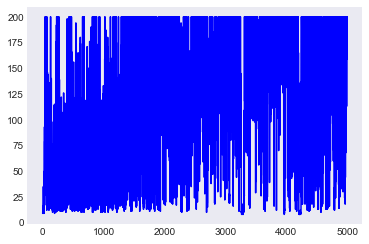

In [5]:
# se muestra el reward/score optenido por episodio
plt.plot(np.array(scores_DuelDQN), label='Dueling_DQN', c='b')
plt.plot(np.array(scoresDDQN), label='Double_DQN', c='r')
plt.plot(np.array(scoresDQN), label='DQN', c='#7e5fa4')
plt.plot(np.array(scoresPolyDual), label='Dual', c='#71bc78')
plt.plot(np.array(scoresPoly), label='Poly', c='#faa76c')
plt.plot(np.array(scoresLineal), label='Lineal', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa por episodio')
plt.legend(loc='upper left')
plt.show()

NameError: name 'meanDDQN' is not defined

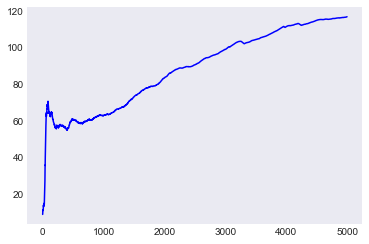

In [7]:
plt.plot(np.array(mean_DuelDQN), label='Dueling_DQN', c='b')
plt.plot(np.array(meanDDQN), label='Double_DQN', c='r')
plt.plot(np.array(meanDQN), label='DQN', c='#7e5fa4')
plt.plot(np.array(meanPolyDual), label='Dual', c='#71bc78')
plt.plot(np.array(meanPoly), label='Poly', c='#faa76c ')
plt.plot(np.array(meanLineal), label='Lineal', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa promedio por episodio')
plt.legend(loc='upper left')
plt.show()

3) Implementación del algoritmo en otro ambiente

In [39]:
env = gym.make('MountainCar-v0')
env.reset()
for _ in range(250):
    env.render(mode='human')
    observation, reward, done, info = env.step(env.action_space.sample()) # se ejecuta una acción aleatoria
    if done:
        env.reset()
env.close()
clear_output()

In [41]:
agent = Double_DQN(gym.make('MountainCar-v0'), n_episodes=1000, debug=True)
scoresDDQN, meanDDQN = agent.run()

[Episode 0] - Mean reward -200.0.
[Episode 100] - Mean reward -200.0.
[Episode 200] - Mean reward -200.0.
[Episode 300] - Mean reward -200.0.
[Episode 400] - Mean reward -199.95261845386534.
[Episode 500] - Mean reward -199.96207584830339.
[Episode 600] - Mean reward -199.9683860232945.
[Episode 700] - Mean reward -199.97289586305277.
[Episode 800] - Mean reward -199.83395755305867.
[Episode 900] - Mean reward -198.19866814650388.
[Episode 999] - Mean reward -198.268.


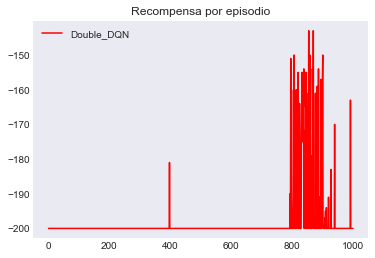

In [45]:
# se muestra el reward/score optenido por episodio
plt.plot(np.array(scoresDDQN), label='Double_DQN', c='r')
#plt.ylim(0, 200)
plt.title('Recompensa por episodio')
plt.legend(loc='upper left')
plt.show()

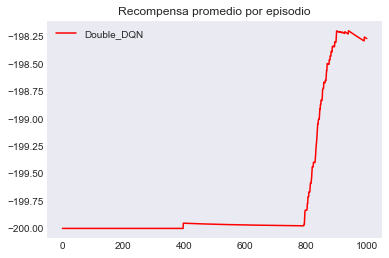

In [46]:
plt.plot(np.array(meanDDQN), label='Double_DQN', c='r')
#plt.ylim(0, 200)
plt.title('Recompensa promedio por episodio')
plt.legend(loc='upper left')
plt.show()